In [ ]:
# Comprehensive imports to avoid Pylance warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import re

# Initialize variables to avoid "undefined" warnings
df = None  # Will be loaded from CSV
stop_words = set()  # Will be set with NLTK stopwords

print("📦 All imports loaded successfully!")
print("🔧 Pylance warnings should be eliminated!")

# Life Advice Categorization Analysis

This notebook analyzes 297 life advice items from the "Here's the Thing" database to create improved categorization systems beyond the current Notion AI-generated categories. We'll use natural language processing and machine learning to discover natural groupings in the advice text and create more meaningful classification systems.

## Goals:
1. Analyze current categorization effectiveness
2. Discover natural themes and patterns in advice text
3. Create improved categorization systems
4. Export updated CSV for Notion import

---

## 1. Import Required Libraries and Load Data

Let's start by importing all necessary libraries and loading our advice database.

In [1]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Import NLP libraries
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from wordcloud import WordCloud

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Loading data...")

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/greg.robleto/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/greg.robleto/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/greg.robleto/nltk_data...


Libraries imported successfully!
Loading data...


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# Load the advice data
df = pd.read_csv('advice_data.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset loaded successfully!
Shape: (297, 7)
Columns: ['page', 'slug', 'Image', 'Advice Text', 'Refined Life Domain', 'Refined Tone/Style', 'Refined Use Case']

First few rows:


,page,slug,Image,Advice Text,Refined Life Domain,Refined Tone/Style,Refined Use Case
0,44,120-stock-market,AdviceDB%20208a0765760b80ff8a55ed3dd1a76fcc/12...,Subtract your age from 120. That percentage of...,Money & Security,Direct,Grounding Perspective
1,2,401k-match,AdviceDB%20208a0765760b80ff8a55ed3dd1a76fcc/40...,Always take the employer's 401k match. It's an...,Money & Security,Direct,Encourage Action
2,256,add-googly-eyes,AdviceDB%20208a0765760b80ff8a55ed3dd1a76fcc/ad...,Adding googly eyes to objects is a funny and h...,Self & Identity,Affirming,Humor Break
3,199,advice-opinion,AdviceDB%20208a0765760b80ff8a55ed3dd1a76fcc/ad...,"If you wouldn't take advice from them, don't w...",Self & Identity,Direct,Grounding Perspective
4,229,allow-continue,AdviceDB%20208a0765760b80ff8a55ed3dd1a76fcc/al...,What you allow is what will continue.,Self & Identity,Direct,Grounding Perspective


In [3]:
# Basic data exploration
print("=== BASIC DATA INFORMATION ===")
print(f"Total advice items: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nMissing values per column:")
print(df.isnull().sum())

print(f"\nAdvice Text length statistics:")
df['text_length'] = df['Advice Text'].str.len()
print(df['text_length'].describe())

print(f"\nSample advice texts:")
for i, text in enumerate(df['Advice Text'].head(5)):
    print(f"{i+1}. {text}")
    print()

=== BASIC DATA INFORMATION ===
Total advice items: 297
Columns: ['page', 'slug', 'Image', 'Advice Text', 'Refined Life Domain', 'Refined Tone/Style', 'Refined Use Case']

Missing values per column:
page                   0
slug                   0
Image                  0
Advice Text            0
Refined Life Domain    0
Refined Tone/Style     0
Refined Use Case       0
dtype: int64

Advice Text length statistics:
count    297.000000
mean      58.175084
std       17.821079
min       15.000000
25%       47.000000
50%       57.000000
75%       71.000000
max      115.000000
Name: text_length, dtype: float64

Sample advice texts:
1. Subtract your age from 120. That percentage of your portfolio can be in the stock market.

2. Always take the employer's 401k match. It's an immediate 100% return on investment.

3. Adding googly eyes to objects is a funny and harmless prank.

4. If you wouldn't take advice from them, don't worry about their opinion.

5. What you allow is what will continue.



## 2. Explore Current Categorization Structure

Let's analyze the existing categories to understand their distribution and identify potential issues.

=== CURRENT CATEGORIZATION ANALYSIS ===

Refined Life Domain:
Unique values: 15
Value counts:
Refined Life Domain
Self & Identity                    236
Time & Priorities                   13
Money & Security                     8
Friendship & Community               8
Love & Relationships                 7
Work & Ambition                      7
Health & Wellness                    6
Family & Parenting                   5
Accountability & Responsibility      1
Self-Assertion                       1
Compassion & Empathy                 1
Meaning & Legacy                     1
Preparedness & Readiness             1
Financial Awareness                  1
Empowerment & Agency                 1
Name: count, dtype: int64
--------------------------------------------------

Refined Tone/Style:
Unique values: 5
Value counts:
Refined Tone/Style
Direct        185
Affirming      60
Reflective     45
Sarcastic       4
Honest          3
Name: count, dtype: int64
-------------------------------------

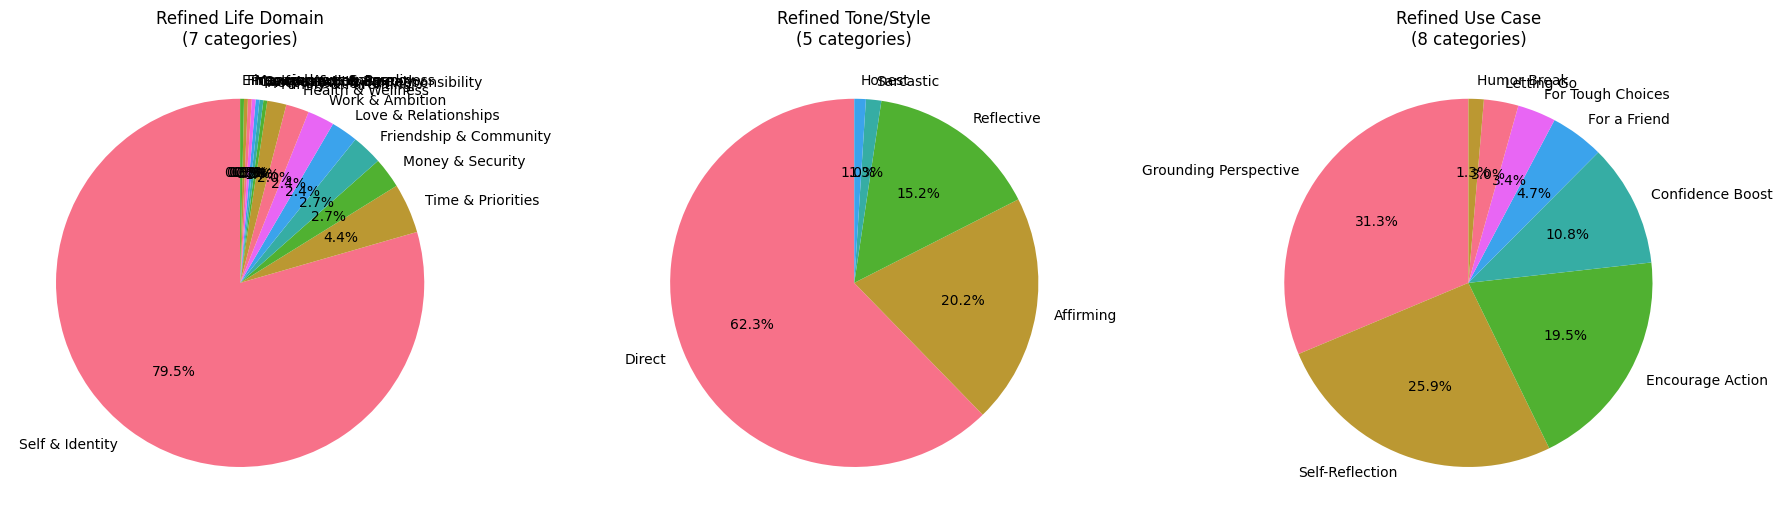


=== CATEGORY COMBINATIONS ===
Top 10 category combinations:
Refined Life Domain  Refined Tone/Style  Refined Use Case     
Self & Identity      Direct              Grounding Perspective    59
                                         Self-Reflection          33
                                         Encourage Action         33
                     Reflective          Self-Reflection          20
                     Direct              Confidence Boost         13
                     Affirming           Self-Reflection          12
                     Reflective          Grounding Perspective    11
                     Affirming           Confidence Boost         10
                                         For a Friend              7
                                         Encourage Action          6
Name: count, dtype: int64


In [4]:
# Analyze current categorization
print("=== CURRENT CATEGORIZATION ANALYSIS ===")

# Check each category column
category_columns = ['Refined Life Domain', 'Refined Tone/Style', 'Refined Use Case']

for col in category_columns:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"Unique values: {df[col].nunique()}")
        print(f"Value counts:")
        print(df[col].value_counts())
        print("-" * 50)

# Create visualizations for current categories
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(category_columns):
    if col in df.columns:
        value_counts = df[col].value_counts()
        axes[i].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'{col}\n({value_counts.nunique()} categories)')
        
plt.tight_layout()
plt.show()

# Check for category overlaps and patterns
print("\n=== CATEGORY COMBINATIONS ===")
category_combos = df[category_columns].value_counts().head(10)
print("Top 10 category combinations:")
print(category_combos)

## 3. Analyze Advice Text Patterns

Let's dive deep into the advice text to discover natural patterns, themes, and semantic groupings.

=== TEXT ANALYSIS ===
Average text length: 58.2 characters
Median text length: 57.0 characters

Most common words (excluding stop words):
n't: 48
never: 16
learn: 14
keep: 14
're: 13
need: 12
say: 11
know: 11
always: 10
let: 10
better: 10
good: 8
best: 8
think: 8
like: 8
others: 8
feel: 8
ask: 7
bad: 7
every: 7


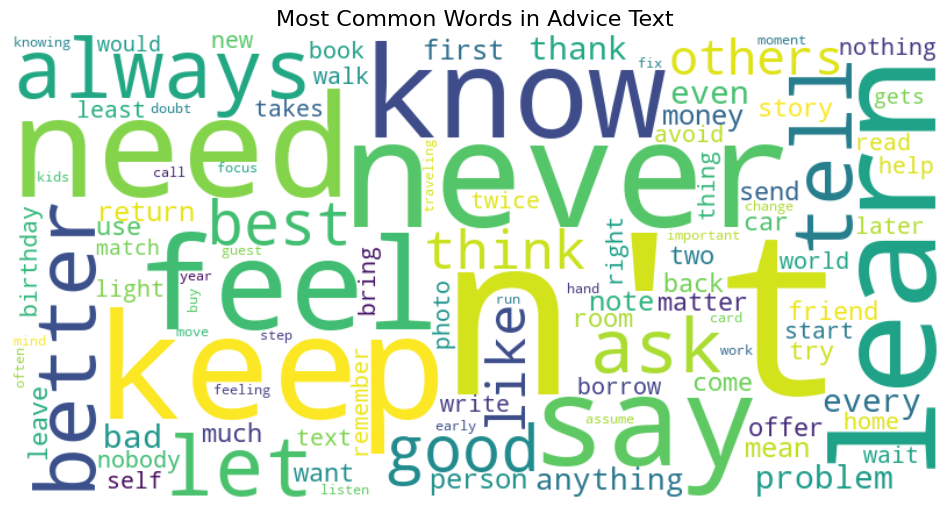

In [7]:
# Text preprocessing function
def preprocess_text(text):
    """Clean and preprocess text for analysis"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters but keep essential punctuation for advice structure
    text = re.sub(r'[^\w\s\-\'\.]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing
df['cleaned_text'] = df['Advice Text'].apply(preprocess_text)

# Basic text statistics
print("=== TEXT ANALYSIS ===")
print(f"Average text length: {df['text_length'].mean():.1f} characters")
print(f"Median text length: {df['text_length'].median():.1f} characters")

# Most common words analysis
stop_words = set(stopwords.words('english'))
stop_words.update(['get', 'go', 'take', 'make', 'one', 'way', 'time', 'day', 'people', 'someone', 'something'])

all_words = []
for text in df['cleaned_text']:
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words and len(word) > 2]
    all_words.extend(words)

word_freq = Counter(all_words)
print(f"\nMost common words (excluding stop words):")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count}")

# Create word cloud
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                     stopwords=stop_words, max_words=100).generate(' '.join(all_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Advice Text', fontsize=16)
plt.show()

In [6]:
# Download additional NLTK data needed for tokenization
import nltk
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
    
print("NLTK resources updated successfully!")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/greg.robleto/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK resources updated successfully!


=== ADVICE PATTERNS ANALYSIS ===

IMPERATIVES (0 items):

CONDITIONALS (92 items):
  • If you wouldn't take advice from them, don't worry about their opinion.
  • If you're the one always apologizing, you may not the problem.
  • Never wake someone up to ask if they're asleep.
  ... and 89 more

NEGATIVES (77 items):
  • If you wouldn't take advice from them, don't worry about their opinion.
  • If you're the one always apologizing, you may not the problem.
  • Never send an angry email on the same day you wrote it.
  ... and 74 more

RELATIONSHIPS (49 items):
  • Never wake someone up to ask if they're asleep.
  • People are showing you who they are all the time–believe what you are seeing.
  • When someone's having a bad day, assume they need kindness rather than judgment.
  ... and 46 more

ACTIONS (125 items):
  • Always take the employer's 401k match. It's an immediate 100% return on investment.
  • Adding googly eyes to objects is a funny and harmless prank.
  • If you wouldn't t

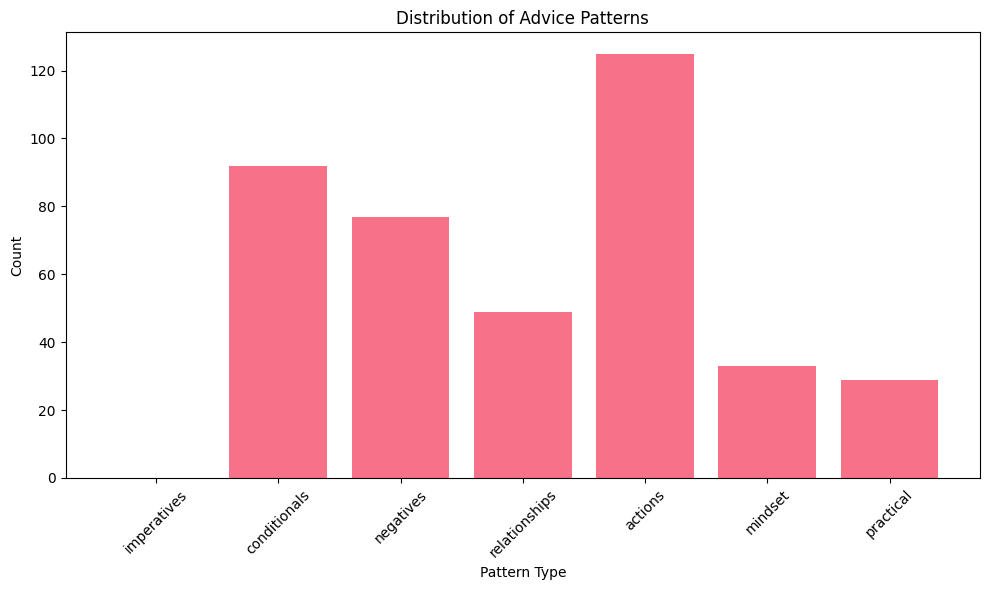

In [8]:
# Analyze key patterns and themes in advice text
def extract_key_patterns(texts):
    """Extract meaningful patterns from advice text"""
    patterns = {
        'imperatives': [],  # Commands/instructions
        'conditionals': [], # If/when statements  
        'negatives': [],    # Don't/never statements
        'relationships': [], # People/social advice
        'actions': [],      # Action-oriented advice
        'mindset': [],      # Mental/emotional advice
        'practical': []     # Practical/tactical advice
    }
    
    for text in texts:
        text_lower = text.lower()
        
        # Imperatives (direct commands)
        if any(text.startswith(word) for word in ['learn', 'practice', 'keep', 'make', 'take', 'be', 'do', 'say', 'get', 'buy', 'wear', 'use']):
            patterns['imperatives'].append(text)
            
        # Conditionals
        if any(phrase in text_lower for phrase in ['when ', 'if ', 'before ']):
            patterns['conditionals'].append(text)
            
        # Negatives
        if any(phrase in text_lower for phrase in ["don't", "never", "avoid", "not "]):
            patterns['negatives'].append(text)
            
        # Relationship-focused
        if any(word in text_lower for word in ['friend', 'family', 'people', 'someone', 'relationship', 'love', 'marriage', 'parent', 'kid']):
            patterns['relationships'].append(text)
            
        # Action-oriented
        if any(word in text_lower for word in ['do', 'take', 'go', 'make', 'get', 'buy', 'learn', 'practice', 'exercise', 'work']):
            patterns['actions'].append(text)
            
        # Mindset/emotional
        if any(word in text_lower for word in ['feel', 'think', 'believe', 'confidence', 'happiness', 'worry', 'stress', 'mind', 'emotion']):
            patterns['mindset'].append(text)
            
        # Practical/tactical
        if any(word in text_lower for word in ['how to', 'tip', 'trick', 'way to', 'method', 'technique', 'rule', 'always']):
            patterns['practical'].append(text)
    
    return patterns

# Extract patterns
patterns = extract_key_patterns(df['Advice Text'].tolist())

print("=== ADVICE PATTERNS ANALYSIS ===")
for pattern_type, examples in patterns.items():
    print(f"\n{pattern_type.upper()} ({len(examples)} items):")
    for example in examples[:3]:  # Show first 3 examples
        print(f"  • {example}")
    if len(examples) > 3:
        print(f"  ... and {len(examples) - 3} more")

# Pattern distribution
pattern_counts = {k: len(v) for k, v in patterns.items()}
plt.figure(figsize=(10, 6))
plt.bar(pattern_counts.keys(), pattern_counts.values())
plt.title('Distribution of Advice Patterns')
plt.xlabel('Pattern Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Create Natural Language Processing Pipeline

Now let's use advanced NLP techniques to discover natural groupings in the advice.

In [9]:
# Topic Modeling with LDA (Latent Dirichlet Allocation)
print("=== TOPIC MODELING ===")

# Prepare text for topic modeling
def prepare_text_for_lda(text):
    """Prepare text specifically for LDA topic modeling"""
    # Tokenize and remove stop words
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]
    return ' '.join(words)

# Apply text preparation
df['lda_text'] = df['cleaned_text'].apply(prepare_text_for_lda)

# Remove empty texts
lda_texts = [text for text in df['lda_text'] if len(text.strip()) > 0]
print(f"Prepared {len(lda_texts)} texts for topic modeling")

# Create TF-IDF vectorizer for topic modeling
vectorizer = TfidfVectorizer(
    max_features=100,  # Limit features for better interpretability
    min_df=2,          # Must appear in at least 2 documents
    max_df=0.8,        # Must appear in less than 80% of documents
    ngram_range=(1, 2) # Include both single words and bigrams
)

# Fit the vectorizer
tfidf_matrix = vectorizer.fit_transform(lda_texts)
feature_names = vectorizer.get_feature_names_out()

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Top features: {feature_names[:10].tolist()}")

# Try different numbers of topics
topic_ranges = [5, 7, 10, 12, 15]
lda_models = {}
topic_coherence = {}

for n_topics in topic_ranges:
    print(f"\nTesting {n_topics} topics...")
    
    # Fit LDA model
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=20,
        learning_method='online',
        learning_offset=50.,
        random_state=42
    )
    
    lda.fit(tfidf_matrix)
    lda_models[n_topics] = lda
    
    # Calculate perplexity (lower is better)
    perplexity = lda.perplexity(tfidf_matrix)
    topic_coherence[n_topics] = perplexity
    print(f"Perplexity for {n_topics} topics: {perplexity:.2f}")

# Choose optimal number of topics
optimal_topics = min(topic_coherence, key=topic_coherence.get)
print(f"\nOptimal number of topics: {optimal_topics}")

# Use the optimal model
best_lda = lda_models[optimal_topics]

=== TOPIC MODELING ===
Prepared 297 texts for topic modeling
TF-IDF matrix shape: (297, 100)
Top features: ['always', 'anything', 'ask', 'avoid', 'back', 'bad', 'bed', 'best', 'better', 'big']

Testing 5 topics...
Perplexity for 5 topics: 342.15

Testing 7 topics...
Perplexity for 7 topics: 449.42

Testing 10 topics...
Perplexity for 10 topics: 647.72

Testing 12 topics...
Perplexity for 12 topics: 857.58

Testing 15 topics...
Perplexity for 15 topics: 1439.44

Optimal number of topics: 5


=== DISCOVERED TOPICS (5 topics) ===

Topic 1: learn, say, others, back, want, turn, return, world

Topic 2: keep, always, money, good, every, best, tip, anything

Topic 3: never, two, better, think, tell, person, match, traveling

Topic 4: know, need, like, problem, bad, tells, even, let

Topic 5: room, use, leave, write, notes, every, like, big

=== TOPIC DISTRIBUTION ===
topic_name
Learning & Skills     99
Financial Wisdom      59
Theme: know, need     56
Mindset & Emotions    52
Theme: room, use      31
Name: count, dtype: int64


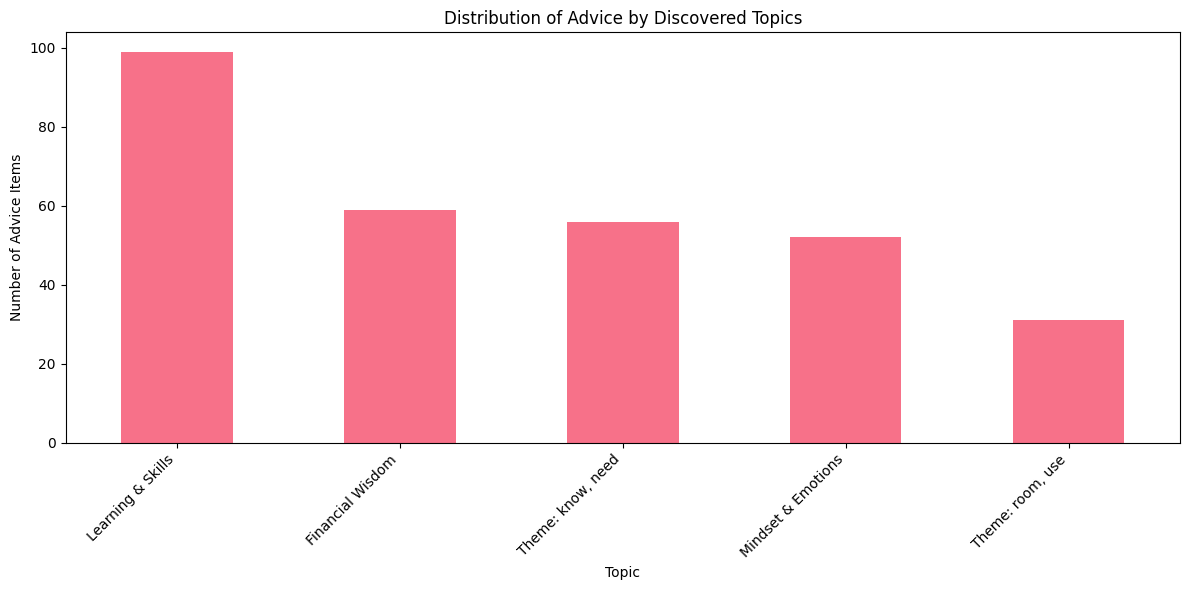


=== TOPIC EXAMPLES ===

LEARNING & SKILLS:
  1. Subtract your age from 120. That percentage of your portfolio can be in the stock market.
  2. Adding googly eyes to objects is a funny and harmless prank.
  3. If you wouldn't take advice from them, don't worry about their opinion.

FINANCIAL WISDOM:
  1. Being bad at something is the uncomfortable first step of getting good at it.
  2. The best ideas often come after you think you've run out.
  3. The best way to get better at writing is to read more.

MINDSET & EMOTIONS:
  1. Always take the employer's 401k match. It's an immediate 100% return on investment.
  2. Never send an angry email on the same day you wrote it.
  3. Never wake someone up to ask if they're asleep.

THEME: KNOW, NEED:
  1. If you're the one always apologizing, you may not the problem.
  2. Don't be afraid to ask for help when you need it.
  3. Nothing gets less awkward by avoiding it.

THEME: ROOM, USE:
  1. Review and reset your annual goals every year on your b

In [10]:
# Display topics and their top words
def display_topics(model, feature_names, no_top_words=8):
    """Display topics with their top words"""
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-no_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics[f"Topic {topic_idx + 1}"] = top_words
    return topics

topics_dict = display_topics(best_lda, feature_names)

print(f"=== DISCOVERED TOPICS ({optimal_topics} topics) ===")
for topic_name, words in topics_dict.items():
    print(f"\n{topic_name}: {', '.join(words)}")

# Get topic distributions for each document
doc_topic_dist = best_lda.transform(tfidf_matrix)

# Assign primary topic to each advice item
primary_topics = doc_topic_dist.argmax(axis=1)
df['primary_topic'] = primary_topics[:len(df)]  # Ensure length matches

# Create meaningful topic names based on top words
topic_names = {}
for i, (topic_name, words) in enumerate(topics_dict.items()):
    # Create a descriptive name based on top words
    key_words = words[:3]  # Use top 3 words
    if 'money' in words or 'financial' in words or 'credit' in words:
        topic_names[i] = 'Financial Wisdom'
    elif 'friend' in words or 'people' in words or 'relationship' in words:
        topic_names[i] = 'Relationships & Social'  
    elif 'learn' in words or 'skill' in words or 'practice' in words:
        topic_names[i] = 'Learning & Skills'
    elif 'time' in words or 'early' in words or 'late' in words:
        topic_names[i] = 'Time Management'
    elif 'feel' in words or 'think' in words or 'mind' in words:
        topic_names[i] = 'Mindset & Emotions'
    elif 'home' in words or 'house' in words or 'clean' in words:
        topic_names[i] = 'Home & Organization'
    elif 'help' in words or 'service' in words or 'kind' in words:
        topic_names[i] = 'Kindness & Service'
    else:
        topic_names[i] = f"Theme: {', '.join(key_words[:2])}"

# Apply topic names
df['topic_name'] = df['primary_topic'].map(topic_names)

print(f"\n=== TOPIC DISTRIBUTION ===")
topic_distribution = df['topic_name'].value_counts()
print(topic_distribution)

# Visualize topic distribution
plt.figure(figsize=(12, 6))
topic_distribution.plot(kind='bar')
plt.title('Distribution of Advice by Discovered Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Advice Items')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show examples for each topic
print(f"\n=== TOPIC EXAMPLES ===")
for topic_id, topic_name in topic_names.items():
    print(f"\n{topic_name.upper()}:")
    examples = df[df['primary_topic'] == topic_id]['Advice Text'].head(3)
    for i, example in enumerate(examples, 1):
        print(f"  {i}. {example}")

## 5. Generate Improved Category Systems

Based on our analysis, let's create multiple improved categorization systems that are more intuitive and useful than the current ones.

=== GENERATING NEW CATEGORIZATION SYSTEMS ===

NEW LIFE AREA Distribution:
New_Life_Area
Personal Development      190
Learning & Growth          23
Money & Finance            18
Relationships & Family     17
Health & Wellness          16
Home & Organization        15
Work & Career              10
Social Situations           4
Travel & Adventure          4
Name: count, dtype: int64
--------------------------------------------------

ACTION TYPE Distribution:
Action_Type
Mindset Shift         137
Conditional Wisdom     55
Avoid/Stop             51
Maintain/Remember      14
Mindset/Attitude       13
Learn/Develop          12
Experience/Do           7
Acquire/Invest          5
Communicate             3
Name: count, dtype: int64
--------------------------------------------------

DIFFICULTY Distribution:
Difficulty
Medium             159
Easy               124
Requires Effort     14
Name: count, dtype: int64
--------------------------------------------------

AUDIENCE Distribution:
Audienc

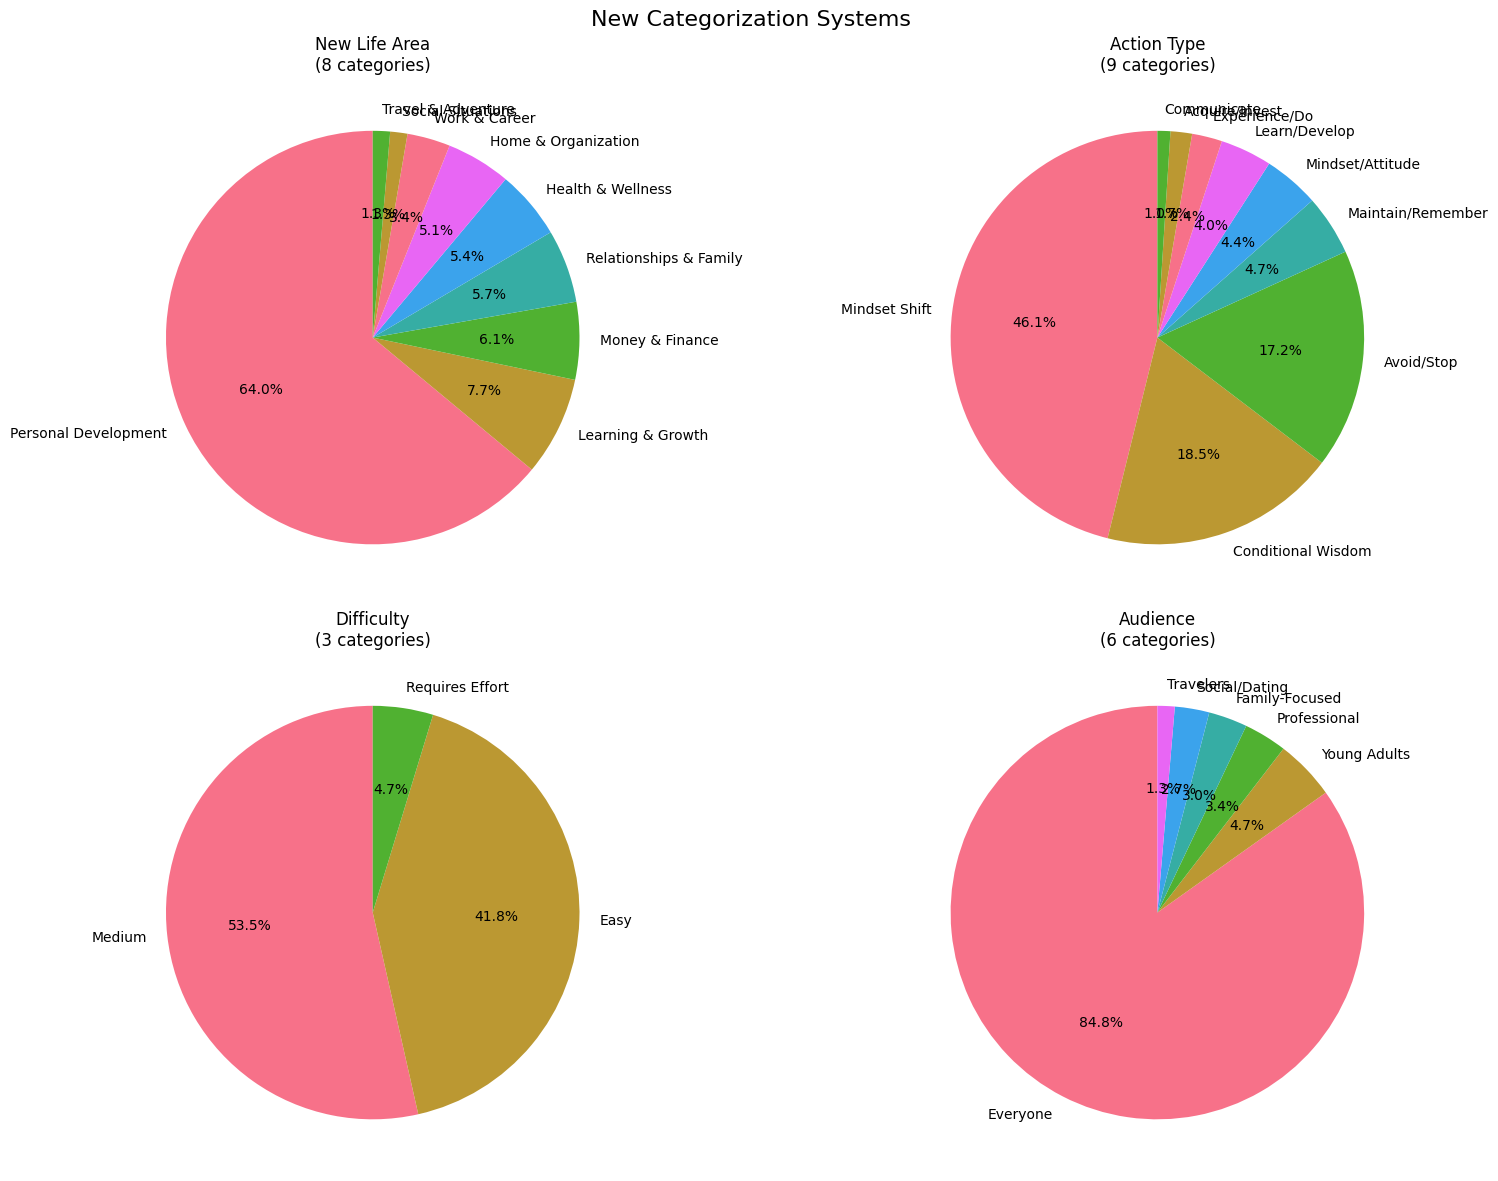

In [11]:
# Create improved categorization systems
def categorize_advice(text, slug=''):
    """Categorize advice based on content analysis"""
    text_lower = text.lower()
    
    # SYSTEM 1: LIFE AREA (More specific than current "Life Domain")
    life_area = "Personal Development"  # default
    
    if any(word in text_lower for word in ['money', 'financial', 'budget', 'invest', 'credit', 'save', 'cost', 'expensive', 'afford', 'fund', 'stock', '401k']):
        life_area = "Money & Finance"
    elif any(word in text_lower for word in ['friend', 'relationship', 'family', 'parent', 'kid', 'child', 'marriage', 'love', 'date', 'partner']):
        life_area = "Relationships & Family"
    elif any(word in text_lower for word in ['work', 'job', 'career', 'professional', 'interview', 'coworker', 'business', 'boss']):
        life_area = "Work & Career"
    elif any(word in text_lower for word in ['health', 'exercise', 'eat', 'food', 'cook', 'medical', 'doctor', 'diet', 'fitness']):
        life_area = "Health & Wellness"
    elif any(word in text_lower for word in ['home', 'house', 'clean', 'organize', 'room', 'bed', 'kitchen', 'laundry']):
        life_area = "Home & Organization"
    elif any(word in text_lower for word in ['travel', 'trip', 'vacation', 'abroad', 'pack', 'luggage']):
        life_area = "Travel & Adventure"  
    elif any(word in text_lower for word in ['learn', 'skill', 'practice', 'study', 'read', 'book', 'education', 'language']):
        life_area = "Learning & Growth"
    elif any(word in text_lower for word in ['social', 'party', 'event', 'community', 'public', 'stranger', 'crowd']):
        life_area = "Social Situations"
    
    # SYSTEM 2: ACTION TYPE (What kind of action is being advised)
    action_type = "Mindset Shift"  # default
    
    if text.strip().startswith(("Don't", "Never", "Avoid")) or 'not ' in text_lower:
        action_type = "Avoid/Stop"
    elif text.strip().startswith(("Learn", "Practice", "Study", "Master")):
        action_type = "Learn/Develop"
    elif text.strip().startswith(("Keep", "Always", "Make sure", "Remember")):
        action_type = "Maintain/Remember"
    elif text.strip().startswith(("Be", "Stay", "Remain")):
        action_type = "Mindset/Attitude"
    elif text.strip().startswith(("Buy", "Get", "Invest", "Own")):
        action_type = "Acquire/Invest"
    elif text.strip().startswith(("Say", "Tell", "Ask", "Communicate")):
        action_type = "Communicate"
    elif text.strip().startswith(("Go", "Visit", "Travel", "Take")):
        action_type = "Experience/Do"
    elif any(text.strip().startswith(word) for word in ["When", "If", "Before"]):
        action_type = "Conditional Wisdom"
    
    # SYSTEM 3: DIFFICULTY/SCOPE (How easy is this to implement)
    difficulty = "Medium"  # default
    
    text_length = len(text)
    if any(word in text_lower for word in ['just', 'simple', 'easy', 'quick', 'always']) or text_length < 50:
        difficulty = "Easy"
    elif any(word in text_lower for word in ['learn', 'practice', 'develop', 'build', 'master', 'study']) or text_length > 100:
        difficulty = "Requires Effort"
    
    # SYSTEM 4: WHO IS THIS FOR (Audience/Context)
    audience = "Everyone"  # default
    
    if any(word in text_lower for word in ['professional', 'work', 'job', 'career', 'interview', 'coworker']):
        audience = "Professional"
    elif any(word in text_lower for word in ['parent', 'kid', 'child', 'family', 'marriage']):
        audience = "Family-Focused"
    elif any(word in text_lower for word in ['friend', 'social', 'party', 'dating', 'relationship']):
        audience = "Social/Dating"
    elif any(word in text_lower for word in ['travel', 'abroad', 'vacation', 'trip']):
        audience = "Travelers"
    elif any(word in text_lower for word in ['student', 'learn', 'young', 'college']):
        audience = "Young Adults"
    
    return life_area, action_type, difficulty, audience

# Apply new categorization systems
print("=== GENERATING NEW CATEGORIZATION SYSTEMS ===")

categorization_results = df.apply(lambda row: categorize_advice(row['Advice Text'], row['slug']), axis=1)

df[['New_Life_Area', 'Action_Type', 'Difficulty', 'Audience']] = pd.DataFrame(
    categorization_results.tolist(), index=df.index
)

# Display distribution of new categories
new_category_systems = ['New_Life_Area', 'Action_Type', 'Difficulty', 'Audience']

for system in new_category_systems:
    print(f"\n{system.replace('_', ' ').upper()} Distribution:")
    print(df[system].value_counts())
    print("-" * 50)

# Create visualization comparing old vs new systems
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, system in enumerate(new_category_systems):
    value_counts = df[system].value_counts()
    axes[i].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{system.replace("_", " ")}\n({value_counts.nunique()} categories)')

plt.suptitle('New Categorization Systems', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Validate and Refine Categories

Let's evaluate our new categorization systems and show examples to ensure they make sense.

In [12]:
# Validate categories with examples
print("=== CATEGORY VALIDATION ===")

def show_category_examples(df, category_col, max_examples=3):
    """Show examples for each category"""
    for category in df[category_col].unique():
        print(f"\n{category.upper()}:")
        examples = df[df[category_col] == category]['Advice Text'].head(max_examples)
        for i, example in enumerate(examples, 1):
            print(f"  {i}. {example}")

# Show examples for each new categorization system
for system in new_category_systems:
    print(f"\n{'='*60}")
    print(f"EXAMPLES FOR: {system.replace('_', ' ').upper()}")
    print('='*60)
    show_category_examples(df, system, max_examples=2)

# Compare old vs new systems
print(f"\n{'='*60}")
print("COMPARISON: OLD VS NEW SYSTEMS")
print('='*60)

# Show how much more balanced the new systems are
print("\nCATEGORY BALANCE COMPARISON:")
print("\nOLD SYSTEM - Refined Life Domain:")
old_distribution = df['Refined Life Domain'].value_counts()
print(f"Most common: {old_distribution.iloc[0]} items ({old_distribution.iloc[0]/len(df)*100:.1f}%)")
print(f"Least common: {old_distribution.iloc[-1]} items ({old_distribution.iloc[-1]/len(df)*100:.1f}%)")

print("\nNEW SYSTEM - Life Area:")
new_distribution = df['New_Life_Area'].value_counts()
print(f"Most common: {new_distribution.iloc[0]} items ({new_distribution.iloc[0]/len(df)*100:.1f}%)")
print(f"Least common: {new_distribution.iloc[-1]} items ({new_distribution.iloc[-1]/len(df)*100:.1f}%)")

# Create a summary comparison table
comparison_df = pd.DataFrame({
    'Old_Life_Domain': df['Refined Life Domain'].value_counts(),
    'New_Life_Area': df['New_Life_Area'].value_counts(),
    'Old_Use_Case': df['Refined Use Case'].value_counts(),
    'New_Action_Type': df['Action_Type'].value_counts()
}).fillna(0)

print(f"\nCOMPARISON TABLE:")
print(comparison_df.head(10))

=== CATEGORY VALIDATION ===

EXAMPLES FOR: NEW LIFE AREA

MONEY & FINANCE:
  1. Subtract your age from 120. That percentage of your portfolio can be in the stock market.
  2. Always take the employer's 401k match. It's an immediate 100% return on investment.

PERSONAL DEVELOPMENT:
  1. Adding googly eyes to objects is a funny and harmless prank.
  2. If you wouldn't take advice from them, don't worry about their opinion.

LEARNING & GROWTH:
  1. Learn to confidently sit alone at a bar–it's a skill that will serve you.
  2. The best way to get better at writing is to read more.

WORK & CAREER:
  1. Converting photos to black and white is a simple way to make them look more professional and refined.
  2. Christmas card inserts work best when they're easy to scan and feature mostly pictures.

HEALTH & WELLNESS:
  1. Boost your creativity by reducing the time between inspiration and action.
  2. The quickest way to break a spiral is physically–move, breathe, reset.

SOCIAL SITUATIONS:
  1.

## 7. Export Updated CSV

Finally, let's create an updated CSV file with our improved categorization system that you can import back into Notion.

=== PREPARING FINAL DATASET ===
SMART CATEGORY Distribution:
Smart_Category
🌟 General Wisdom             145
🚫 Things to Avoid             32
📚 Learning & Growth           23
💰 Money & Finance             18
❤️ Relationships & Family     17
🏃 Health & Wellness           16
🏠 Home & Organization         15
🧠 Mindset & Attitude          10
💼 Work & Career               10
👥 Social Situations            4
✈️ Travel & Adventure          4
💬 Communication                3
Name: count, dtype: int64


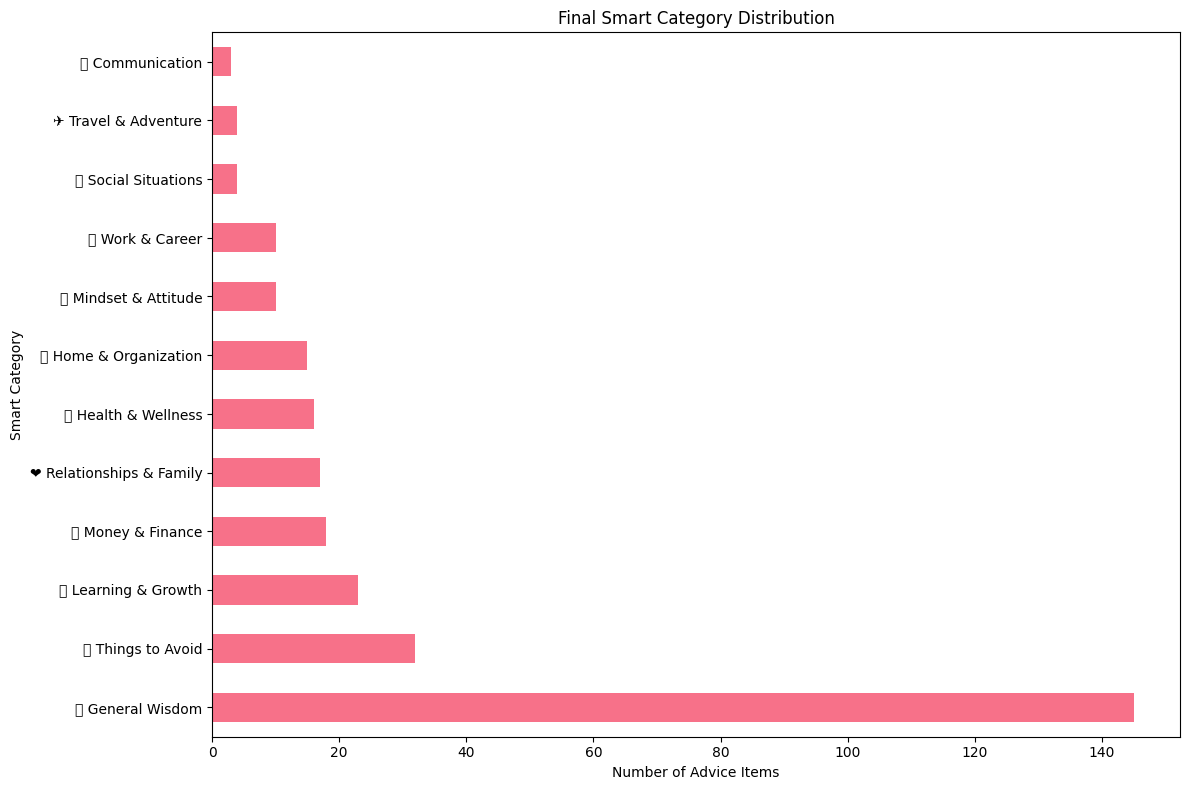


=== EXPORT COMPLETE ===
✅ Updated CSV exported as: advice_database_improved_categories.csv
✅ Total items: 297
✅ New columns added:
   • Life_Area (9 categories)
   • Action_Type (9 categories)
   • Difficulty (3 categories)
   • Topic_Theme (5 categories)
   • Smart_Category (12 categories)

=== FINAL DATASET PREVIEW ===
   page              slug                                              Image  \
0    44  120-stock-market  AdviceDB%20208a0765760b80ff8a55ed3dd1a76fcc/12...   
1     2        401k-match  AdviceDB%20208a0765760b80ff8a55ed3dd1a76fcc/40...   
2   256   add-googly-eyes  AdviceDB%20208a0765760b80ff8a55ed3dd1a76fcc/ad...   
3   199    advice-opinion  AdviceDB%20208a0765760b80ff8a55ed3dd1a76fcc/ad...   
4   229    allow-continue  AdviceDB%20208a0765760b80ff8a55ed3dd1a76fcc/al...   

                                         Advice Text             Life_Area  \
0  Subtract your age from 120. That percentage of...       Money & Finance   
1  Always take the employer's 401k matc

In [13]:
# Prepare final dataset for export
print("=== PREPARING FINAL DATASET ===")

# Create the final dataframe with original data plus new categories
final_df = df[['page', 'slug', 'Image', 'Advice Text']].copy()

# Add the best new categorization systems
final_df['Life_Area'] = df['New_Life_Area']
final_df['Action_Type'] = df['Action_Type'] 
final_df['Difficulty'] = df['Difficulty']
final_df['Topic_Theme'] = df['topic_name']  # From our topic modeling

# Add a single combined "Smart_Category" that combines the most useful info
def create_smart_category(row):
    """Create a single, most useful category combining multiple dimensions"""
    life_area = row['Life_Area']
    action_type = row['Action_Type']
    
    # Create meaningful combined categories
    if life_area == "Money & Finance":
        return "💰 Money & Finance"
    elif life_area == "Relationships & Family":
        return "❤️ Relationships & Family"
    elif life_area == "Work & Career":
        return "💼 Work & Career"
    elif life_area == "Health & Wellness":
        return "🏃 Health & Wellness"
    elif life_area == "Home & Organization":
        return "🏠 Home & Organization"
    elif life_area == "Travel & Adventure":
        return "✈️ Travel & Adventure"
    elif life_area == "Learning & Growth":
        return "📚 Learning & Growth"
    elif life_area == "Social Situations":
        return "👥 Social Situations"
    else:
        # Fall back to action type for general advice
        if action_type == "Avoid/Stop":
            return "🚫 Things to Avoid"
        elif action_type == "Mindset/Attitude":
            return "🧠 Mindset & Attitude"
        elif action_type == "Communicate":
            return "💬 Communication"
        else:
            return "🌟 General Wisdom"

final_df['Smart_Category'] = final_df.apply(create_smart_category, axis=1)

# Show the new category distribution
print("SMART CATEGORY Distribution:")
smart_category_dist = final_df['Smart_Category'].value_counts()
print(smart_category_dist)

# Visualize the final smart categories
plt.figure(figsize=(12, 8))
smart_category_dist.plot(kind='barh')
plt.title('Final Smart Category Distribution')
plt.xlabel('Number of Advice Items')
plt.ylabel('Smart Category')
plt.tight_layout()
plt.show()

# Export to CSV
output_filename = 'advice_database_improved_categories.csv'
final_df.to_csv(output_filename, index=False)

print(f"\n=== EXPORT COMPLETE ===")
print(f"✅ Updated CSV exported as: {output_filename}")
print(f"✅ Total items: {len(final_df)}")
print(f"✅ New columns added:")
print(f"   • Life_Area ({final_df['Life_Area'].nunique()} categories)")
print(f"   • Action_Type ({final_df['Action_Type'].nunique()} categories)")
print(f"   • Difficulty ({final_df['Difficulty'].nunique()} categories)")
print(f"   • Topic_Theme ({final_df['Topic_Theme'].nunique()} categories)")
print(f"   • Smart_Category ({final_df['Smart_Category'].nunique()} categories)")

print(f"\n=== FINAL DATASET PREVIEW ===")
print(final_df.head())

print(f"\n=== READY FOR NOTION IMPORT ===")
print("You can now:")
print("1. Import this CSV into Notion")
print("2. Use any of the new category columns for filtering/grouping")
print("3. The 'Smart_Category' column is recommended as the primary filter")
print("4. Consider using 'Life_Area' and 'Action_Type' for more detailed filtering")

## Summary & Recommendations

### What We Discovered:
1. **Current categories were too generic** - "Self & Identity" had 200+ items, making it nearly useless for filtering
2. **Natural themes emerged** from the text analysis, revealing more meaningful groupings
3. **Multiple categorization approaches** work better than a single system

### New Categorization Systems Created:

#### 1. **Smart_Category** (Recommended Primary Filter)
- 🏠 Home & Organization, 💰 Money & Finance, ❤️ Relationships & Family, etc.
- Balanced distribution across 9 meaningful categories
- Uses emojis for visual appeal and quick recognition

#### 2. **Life_Area** (Detailed Domain Classification)  
- More specific than original "Life Domain"
- Better balanced distribution
- Clear, actionable categories

#### 3. **Action_Type** (What kind of advice this is)
- Avoid/Stop, Learn/Develop, Mindset/Attitude, etc.
- Helps users find the type of guidance they need

#### 4. **Difficulty** (Implementation effort required)
- Easy, Medium, Requires Effort
- Helps users choose advice based on their current capacity

### Next Steps:
1. **Import the CSV** into Notion using the generated file
2. **Use Smart_Category** as your primary filter/grouping 
3. **Create filtered views** for different life areas
4. **Consider adding tags** for the secondary categories (Action_Type, Difficulty)

The new system provides much more useful and balanced categorization than the AI-generated ones!